In [1]:
from __future__ import division # always-float division
import numpy as np
import pandas as pd
import glob
import pprint
import os
import requests
from datetime import date

# Easy interactive plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Interactive plots in notebook
from IPython.display import HTML, Image, display
from ipywidgets.widgets import interact, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed, Checkbox

# Maths
from scipy.integrate import odeint
import scipy.signal.windows as window
from sklearn.preprocessing import normalize
import scipy.stats as stats

# ISO codes for OWID data
import pycountry

# Long computations
from tqdm import tqdm_notebook as tqdm
import pickle

# Fitter
from lmfit import Model, Parameters, Parameter, report_fit, minimize

# Interactive plot layout options
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

Execution options:
- `STATIC_PLOTS` must be set to `True` to display figures in Github (or a non-JS renderer)
- if `COUNTRY` is not a valid one, it will search France by default
- `DATA_PATH` works just fine with the current repo folders

In [2]:
# Relative path to EPI data folder
DATA_PATH = './data/clean/EPI'
# Studied country for OWID data
COUNTRY = 'France'
DEATHS_FILE = 'total_deaths_10juillet2020.csv'
# Initial values of parameters for model fit
PARAMS_FILE = './params.csv'
# Display static (png) plots or interactive plotly (js) figures
STATIC_PLOTS = True

## Functions

### Data-getting

In [3]:
def download_csv(url, path, prefix):
    """
    Downloads a CSV from 'url', saves it to 'path' folder with filename 'prefix'_DD-MM-YYYY formatted at today's date
    """
    response = requests.get(url, allow_redirects=True)
    today = str(date.today())
    filepath = f'{path}/{prefix}_{today}.csv'
    open(filepath, 'wb').write(response.content)
    return filepath

def update_owid(path):
    """
    Updates Our World In Data database and saves it to 'path' folder. Renames it to owid_DD-MM-YYYY with today's date
    """
    filepath = download_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', path, 'owid')
    print(f'Downloaded Our World In Data Coronavirus data to \n\t{filepath}')
    return filepath

def update_hospitalieres(path):
    """
    Updates Santé Publique France - Données Hospitalières database and saves it to 'path' folder. Renames it to hospitalieres_DD-MM-YYYY with today's date
    """
    filepath = download_csv('https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7', path, 'hospitalieres')
    print(f'Downloaded Données hospitalières Santé Publique data to \n\t{filepath}')
    return filepath

def countries_owid(file):
    """
    Return list of countries in an OWID database from 'file'
    """
    data = pd.read_csv(file, sep=",",header=0)
    return data['iso_code'].unique()

def extract_owid(file, country_code='FRA'):
    """
    Extracts 'country_code' data from OWID database (date, I, D, s), creates country attributes from single-valued columns
    """
    # Open, country-filter & relevant column-filer data
    data = pd.read_csv(file, sep=",",header=0)
    countries = data['iso_code'].unique()
    if country_code not in countries:
        country_code = 'FRA'
        print('Invalid country code, extracting France by default')
    data = data[data['iso_code'] == country_code]
    cols = ['date', 'total_cases', 'total_deaths', 'stringency_index', 'population']
    # Drop unnecesary columns
    data = data.drop([c for c in data.columns if c not in cols], axis=1)
    # Get single-valued columns to return as country attribute
    uniques = unique_columns(data)
    attrs = {}
    for col in uniques:
        attrs[col] = data[col].iloc[0]
    # Drop single-valued columns
    data = data.drop(uniques, axis=1)
    data.reset_index(drop=True, inplace=True)
    return data, attrs

def hospitalieres_summary(file):
    """
    Creates national summary database from daily hospitary data per department, saved in 'file'
    """
    # Open CSV & create df with present dates
    data = pd.read_csv(file, sep=";",header=0)
    new_df = pd.DataFrame()
    dates= data['jour'].unique()
    new_df['date'] = dates
    # Filter data: separate male & female 
    data = data[data['sexe'] != 0]
    # For relevant columns (hospitalized, dead, sent to home, in reanimation) sum for all departments in a given day
    for c in ['hosp', 'rea', 'rad']:
        cum_data = data.groupby('jour')[c].sum().to_numpy()
        # Assign relevant summarized column to storage df
        new_df[c] = cum_data
    return new_df

def datefy(s):
    """
    returns YYYY-MM-DD from YYYY-MM-DD or DD/MM/YYYY
    """
    l2 = s.split('/')
    if len(s.split('-')) == 3:
        return s
    elif len(l2) == 3:
        return '-'.join(reversed(l2))
    else:
        print('Non consistent date format')
        return 'nan'


def country_covid(country, owid_file, hosp_file=''):
    """
    Extracts 'country' time series from OWID database saved in 'owid_file'. Can add hospital data if 'country'==France and 'hosp_file' is specified.
    Time series starts when infected are positive
    """
    # Get ISO-3 code for country to later use as index for OWID database
    try:
        code = pycountry.countries.search_fuzzy(country)[0].alpha_3
    except LookupError:
        print(f'{country} not found in country dictionary.')
        return
    covid_data, country_attrs = extract_owid(owid_file, country_code=code)
    # France case with hospital data
    if code == 'FRA' and hosp_file != '':
        hosp_database = hospitalieres_summary(hosp_file)
        # Fix date notation
        hosp_database.date = hosp_database.date.apply(lambda s: datefy(s))
        # Mean date duplicates
        hosp_database = hosp_database.groupby(by='date', as_index=False).mean()
        covid_data = hosp_database.merge(covid_data, on='date', how='outer')
        covid_data = covid_data.sort_values(by='date')
        covid_data = covid_data.reset_index(drop=True)
        # Oldest EPI values are all 0 (I, R, D)
        covid_data.loc[0, covid_data.columns != 'date'] = covid_data.loc[0, covid_data.columns != 'date'].apply(lambda x: 0)
        # Forward-fill NaN: old value is maintained until not-NaN value
        covid_data.ffill(axis=0, inplace=True)
        # Rename columns
        covid_data.columns = ['date', 'H', 'Reanimation', 'R', 'I', 'D', 's']
        # Compute S
        covid_data['S'] = country_attrs['population'] - covid_data['I'] - covid_data['D'] - covid_data['H'] - covid_data['Reanimation']
    # general country 
    else:
        covid_data = covid_data.sort_values(by='date')
        covid_data = covid_data.reset_index(drop=True)
        # Oldest EPI values are all 0 (I, R, D)
        covid_data.loc[0, covid_data.columns != 'date'] = covid_data.loc[0, covid_data.columns != 'date'].apply(lambda x: 0)
        # Forward-fill NaN: old value is maintained until not-NaN value
        covid_data.ffill(axis=0, inplace=True)
        # Rename columns
        covid_data.columns = ['date', 'I', 'D', 's']
        # Compute S
        covid_data['S'] = country_attrs['population'] - covid_data['I'] - covid_data['D']
    covid_data = covid_data[covid_data['I'] > 0]
    covid_data.reset_index(drop=True, inplace=True)
    covid_data['N_effective'] = country_attrs['population'] - covid_data['D']
#     covid_data['beta'] = -covid_data['N_effective'] * covid_data['S'].diff() / (covid_data['I'] * covid_data['S'])
#     covid_data['mu'] = covid_data['D'].diff() / covid_data['I']
    covid_data.bfill(axis=0, inplace=True)

    return covid_data, country_attrs

def unique_columns(df):
    """
    Return name of columns with an unique value
    """
    return [c for c in df.columns if len(df[c].unique()) == 1]

### Plotting

In [4]:
def plot_dualaxis(x, y1, y2, namesy1, namesy2, title='', log_y2=False, static=False, xtitle='Day'):
    """
    Plots in plotly on dual y axis with a common 'x' series (Days). 'namesy1' and 'namesy2' specify variable names for series in 'y1' and 'y2' respectively.
    Last item in 'namesy1' and 'namesy2' is title of the axis (len is 1-bigger than y1, y2 respectively)
    'log_y2' flag for log scale on second axis, 'title' is plot title and 'static' is flag for png or interactive js plotly
    """
    if type(y1) != list:
        y1 = [y1]
    if type(y2) != list:
        y2 = [y2]
    if type(namesy1) != list:
        namesy1 = [namesy1, namesy1]
    if type(namesy2) != list:
        namesy2 = [namesy2, namesy2]
    if type(x) == int:
        tspan = np.arange(0, x, 1)
    else:
        tspan = x
        
    scale = 'linear'
    if log_y2:
        scale = 'log'
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    for yi in range(len(y1)):
        fig.add_trace(go.Scatter(x=tspan, y=y1[yi], mode='lines+markers', name=namesy1[yi]))
    for yj in range(len(y2)):
        fig.add_trace(go.Scatter(x=tspan, y=y2[yj], mode='lines+markers', name=namesy2[yj]), secondary_y=True)
    
    fig.update_layout(title=title,
                           xaxis_title=xtitle,
                           yaxis_title=namesy1[-1],
                           yaxis2_title=namesy2[-1],
                           yaxis2_type=scale,
                           title_x=0.5,
                          width=1000, height=600
                         )

    if static:
        img_bytes = fig.to_image(format="png")
        display(Image(img_bytes))
    else:
        fig.show()
        
def simulate_plot(result, days, initial_conditions, static=False):
    """
    Simulation plot for 'result' fitted model parametes, for 'days' timespan and 'initial_conditions'
    """
    params = result.params
    tspan = tspan = np.arange(0, days, 1)
    n_sectors = len(initial_conditions)
    sol = np.zeros((days, 3))
    for i in range(n_sectors):
        sol_i = ode_solver(tspan, initial_conditions[i], params, i)
        sol += sol_i[:, 2:5]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tspan, y=sol[:, 0], mode='lines+markers', name='Infections'))
    fig.add_trace(go.Scatter(x=tspan, y=sol[:, 1], mode='lines+markers', name='Recovered'))
    fig.add_trace(go.Scatter(x=tspan, y=sol[:, 2], mode='lines+markers', name='Deaths'))
    fig.update_layout(title='SEIRD per sector: Simulation',
                           xaxis_title='Day',
                           yaxis_title='Counts',
                           title_x=0.5,
                          width=1000, height=600
                         )
    if STATIC_PLOTS:
        img_bytes = fig.to_image(format="png")
        display(Image(img_bytes))
    else:
        fig.show()

def show_rates(result, df, tspan):
    """
    Show fitted rates from 'result' and visualize stringency from 'df' over 'tspan'
    """
    pnames = list((result.params.valuesdict()))
    b_params = [result.params[p].value for p in pnames[:4]]
    m_params = [result.params[p].value for p in pnames[4:8]]
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=tspan, y=logistic_step(tspan, b_params), mode='lines+markers', name='Transmission rate',line = dict(dash='dot', color='orange')))
    fig.add_trace(go.Scatter(x=tspan, y=logistic_step(tspan, m_params), mode='lines+markers', name='Morbidity rate',line = dict(dash='dot', color='purple')))
    
    fig.add_trace(go.Scatter(x=tspan, y=df.s, mode='lines+markers', name='Stringency', line = dict(dash='dot', color='green')), secondary_y=True)
    
    fig.update_layout(title='Fitted compartment rates & stringency data',
                           xaxis_title='Days since first infected',
                           yaxis_title='Rate value',
                           yaxis2_title='OxCGRT index',
                           title_x=0.5,
                           title_font_size=18,
                           font_size=18,
                          width=1000, height=600
                         )
    if STATIC_PLOTS:
        img_bytes = fig.to_image(format="png")
        display(Image(img_bytes))
    else:
        fig.show()

### Model definition

Sector-based SEIRD(F) epidemiological model with no transport between compartments.

#### Auxiliary functions

In [5]:
def logistic(x, L, k, x0):
    """
    Logistic function on 'x' with 'L' maximum value, 'k' steepness and 'x0' midpoint
    """
    return L/(1+np.exp(-k*(x-x0)))

def logistic_params(x, params):
    """
    Logistic function from a list of parameters 'params'=[L, k, x0]
    """
    L, k, x0 = params
    return logistic(x, L, k, x0)

def logistic_step(t, params):
    """
    Not-0 baseline logistic function with 'params'=[C, L, a, b] where
        C initial value
        C+L final value
        a step steepness (a>0)
        b step midpoint 
    """
    C, L, a, b = params
    return C + logistic(t, L, a, b)

#### ODE model

In [6]:
def SIRD_derivs(z, t, rate_params, evo_params):
    """
    Derivatives for ODE solver
    """
    # Separate compartments
    S, E, I, R, D, F = z
    N = S + E + I + R + D + F
    sigma, gamma, mu, nu = rate_params
    # Define evolution rates
    beta_params, mu_params = evo_params    
    beta= logistic_step(t, beta_params)
    mu = logistic_step(t, mu_params)
    # Compartment derivatives
    dSdt = -beta*S*I/(N-D) - nu*S
    dEdt = beta*S*I/(N-D) - sigma*E
    dIdt = sigma*E - gamma*I - mu*I
    dRdt = gamma*I
    dDdt = mu*I 
    dFdt = nu*S
    return [dSdt, dEdt, dIdt, dRdt, dDdt, dFdt]

def ode_solver(t, initial_conditions, params, i):
    """
    ODE solver per sector
    """
    initE, initI, initR, initN, initD, initF = initial_conditions
    # Make param lists
    sigma, gamma, mu, nu = params['sigma'].value, params['gamma'].value, params['mu'].value, params['nu'].value
    # beta and mu params
    C, L, a, b = params[f'C_{i}'].value, params[f'L_{i}'].value, params[f'a_{i}'].value, params[f'b_{i}'].value
    muC, muL, mua, mub = params[f'muC_{i}'].value, params[f'muL_{i}'].value,params[f'mua_{i}'].value, params[f'mub_{i}'].value
    # initial Susceptible
    initS = initN - (initE + initI + initR + initD + initF)
    # Static params and param lists
    rate_params = [sigma, gamma, mu, nu]
    beta_params = [C, L, a, b]
    mu_params = [muC, muL, mua, mub]
    evo_params = [beta_params, mu_params]
    # Solve ODE
    res = odeint(SIRD_derivs, [initS, initE, initI, initR, initD, initF], t, args=(rate_params, evo_params))
    return res

### Solver functions

For initial conditions and error function and wrap-up fit

In [7]:
def init_sectors(sector_props, disease_vary=True, initN=0):
    """
    Makes initial conditions for each sector: one infected and parameter initial values for optimization.
        'disease_params' are initial values for sigma, gamma mu, nu
        'sector_props' is a list of the proportion of the population in each sector
        'disease_vary' freezes disease_params for optimization
    """
    assert abs(np.sum(sector_props) - 100) < 0.1, "Sector population proportions aren't normalized"
    initial_conditions = []
    params = Parameters()
    init_params = pd.read_csv(PARAMS_FILE, sep=";",index_col='name', header=0, skipinitialspace=True)
#     print('Fitted parameter list:')
#     print(init_params)
    for i in range(len(sector_props)):
        initN_i = initN * sector_props[i]/100
        initE_i = 0
        initI_i = 1
        initR_i = 0
        initD_i = 0
        initF_i = 0
        initial_conditions_i = [initE_i, initI_i, initR_i, initN_i, initD_i, initF_i]
        initial_conditions.append(initial_conditions_i)
        params.add(f'C_{i}', value=init_params.at['C', 'init_value'], min=init_params.at['C', 'min'], max=init_params.at['C', 'max'], vary=True)
        params.add(f'L_{i}', value=init_params.at['L', 'init_value'], min=init_params.at['L', 'min'], max=init_params.at['L', 'max'], vary=True)
        params.add(f'a_{i}', value=init_params.at['a', 'init_value'], min=init_params.at['a', 'min'], max=init_params.at['a', 'max'], vary=True)
        params.add(f'b_{i}', value=init_params.at['b', 'init_value'], min=init_params.at['b', 'min'], max=init_params.at['b', 'max'], vary=True)
        params.add(f'muC_{i}', value=init_params.at['muC', 'init_value'], min=init_params.at['muC', 'min'], max=init_params.at['muC', 'max'], vary=True)
        params.add(f'muL_{i}', value=init_params.at['muL', 'init_value'], min=init_params.at['muL', 'min'], max=init_params.at['muL', 'max'], vary=True)
        params.add(f'mua_{i}', value=init_params.at['mua', 'init_value'], min=init_params.at['mua', 'min'], max=init_params.at['mua', 'max'], vary=True)
        params.add(f'mub_{i}', value=init_params.at['mub', 'init_value'], min=init_params.at['mub', 'min'], max=init_params.at['mub', 'max'], vary=True)
        
    params.add('sigma', value=init_params.at['sigma', 'init_value'], min=init_params.at['sigma', 'min'], max=init_params.at['sigma', 'max'], vary=disease_vary)
    params.add('gamma', value=init_params.at['gamma', 'init_value'], min=init_params.at['gamma', 'min'], max=init_params.at['gamma', 'max'], vary=disease_vary)
    params.add('mu', value=init_params.at['mu', 'init_value'], min=init_params.at['mu', 'min'], max=init_params.at['mu', 'max'], vary=disease_vary)
    params.add('nu', value=init_params.at['nu', 'init_value'], min=init_params.at['nu', 'min'], max=init_params.at['nu', 'max'], vary=False)
    
    return params, initial_conditions

def error_sectors(params, initial_conditions, tspan, data, eps):
    n_sectors = len(initial_conditions)
    sol = np.zeros_like(data)
    for i in range(n_sectors):
        sol_i = ode_solver(tspan, initial_conditions[i], params, i)
        # I   
        sol[:,0] += sol_i[:, 2]
        # D   
        sol[:,1] += sol_i[:, 4]       
    return ((sol - data)/eps).ravel()

def fit(country='France', out_days=0, plot=True, disease_vary=True, sector_props=[100.0]):
    try:
        EPI_data, country_attrs = country_covid(country, owid_file, hosp_file)
    except ValueError:
        print(f'incomplete data on {country}')
        return [], []
    # Add daily deaths data if available
    if DEATHS_FILE != '' and country == 'France':
        deaths_data = pd.read_csv(DATA_PATH+'/'+DEATHS_FILE, sep=",",header=0)
        EPI_data = EPI_data.merge(deaths_data, on='date', how='outer')
        # Compute collateral deaths
        EPI_data['F'] = EPI_data['D_total'] - EPI_data['D']
        EPI_data.drop(['D_total'], axis=1, inplace=True)
        EPI_data['dD'] = EPI_data['D'].diff()
        EPI_data['dF'] = EPI_data['F'].diff()
        EPI_data.ffill(axis=0, inplace=True)
        EPI_data.bfill(axis=0, inplace=True)
        df = EPI_data.drop(['H', 'Reanimation', 'N_effective'], axis=1).reindex(columns=['date', 'S', 'I', 'R', 'D', 'F', 's'])
    else:
        df = EPI_data.drop(['N_effective'], axis=1).reindex(columns=['date', 'S', 'I', 'D', 's'])
    
    df.ffill(axis=0, inplace=True)
    df.bfill(axis=0, inplace=True)
    df = df[df['date'] < str(date.today())]
    initN = country_attrs['population']
    params, initial_conditions = init_sectors(sector_props, disease_vary=disease_vary, initN=initN)
    data_full = df.loc[0:(len(df)-1), ['I', 'D']].values
    days = len(df) - out_days
    eps=1.0
    # initial_conditions = [initE, initI, initR, initN, initD]
    tspan = np.arange(1, days+1, 1)
    data = df.loc[0:(days-1), ['I', 'D']].values
    data_s = df.loc[0:(days-1), 's'].values
    if plot:
        print(f'Fitting {country} data with {out_days} last days out')
    # fit model and find predicted values
    result = minimize(error_sectors, params, args=(initial_conditions, tspan, data, eps), method='leastsq', full_output = 1)
    if plot:
        print(report_fit(result))

        print(f'{days} fitted days out of {days+out_days} available data points')

    final = data + result.residual.reshape(data.shape)
    tspan_full = np.arange(1, days+out_days+1, 1)
    
    if plot:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=tspan_full, y=data[:, 0], mode='markers', name='Observed Infections',line = dict(dash='dot', color='red')))
        fig.add_trace(go.Scatter(x=tspan_full, y=data[:, 1], mode='markers', name='Observed COVID Deaths', line = dict(dash='dot', color='blue')))
        # fig.add_trace(go.Scatter(x=tspan_full, y=data[:, 2], mode='markers', name='Observed Collateral Deaths', line = dict(dash='dot')))
        fig.add_trace(go.Scatter(x=tspan_full, y=final[:, 0], mode='lines+markers', name='Fitted Infections',line = dict(dash='dot', color='orange')))
        fig.add_trace(go.Scatter(x=tspan_full, y=final[:, 1], mode='lines+markers', name='Fitted Deaths',line = dict(dash='dot', color='purple')))
        # fig.add_trace(go.Scatter(x=tspan_full, y=final[:, 2], mode='lines+markers', name='Fitted Collateral Deaths'))
        if out_days > 0:
            fig.add_trace(go.Scatter(x=tspan_full, y=data_full[:, 0], mode='markers', name='Observed Infections (Full)', line = dict(dash='dot')))
            fig.add_trace(go.Scatter(x=tspan_full, y=data_full[:, 1], mode='markers', name='Observed Deaths (Full)', line = dict(dash='dot')))
        #     fig.add_trace(go.Scatter(x=tspan_full, y=data_full[:, 2], mode='markers', name='Observed Collateral Deaths (Full)', line = dict(dash='dot')))

        fig.update_layout(title='SEIRD per sector: Observed vs Fitted',
                               xaxis_title='Days since first infected',
                               yaxis_title='Counts',
                               title_x=0.5,
                               title_font_size=18,
                               font_size=18,
                              width=1000, height=600
                             )
        if STATIC_PLOTS:
            img_bytes = fig.to_image(format="png")
            display(Image(img_bytes))
        else:
            fig.show()

        show_rates(result, df, tspan)
    
    return data_s, result, initN

## Data import

From [Our World in Data](https://ourworldindata.org/coronavirus-source-data) and [Santé Publique France](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/)

In [8]:
# Download OWID & Santé Publique data, write new file if new date
existing = glob.glob(DATA_PATH+"/*"+str(date.today())+".csv")
if len(existing) != 2:
    owid_file = update_owid(DATA_PATH)
    hosp_file = update_hospitalieres(DATA_PATH)
else:
    owid_file = existing[1]
    hosp_file = existing[0]
    print(f'Our World In Data Coronavirus data available at\n\t{owid_file}\nDonnées hospitalières Santé Publique data available at\n\t{hosp_file}')

Our World In Data Coronavirus data available at
	./data/clean/EPI\owid_2020-08-10.csv
Données hospitalières Santé Publique data available at
	./data/clean/EPI\hospitalieres_2020-08-10.csv


In [9]:
print("Available files:\n\t"+'\n\t'.join(glob.glob(DATA_PATH+"/*")))

Available files:
	./data/clean/EPI\deps_population.csv
	./data/clean/EPI\france.csv
	./data/clean/EPI\france_attrs.csv
	./data/clean/EPI\france_departments.csv
	./data/clean/EPI\hospitalieres_2020-08-10.csv
	./data/clean/EPI\owid_2020-08-10.csv
	./data/clean/EPI\total_deaths_10juillet2020.csv


### Series visualization

Load data an plot existing time series for $I$, $D$ and $s$

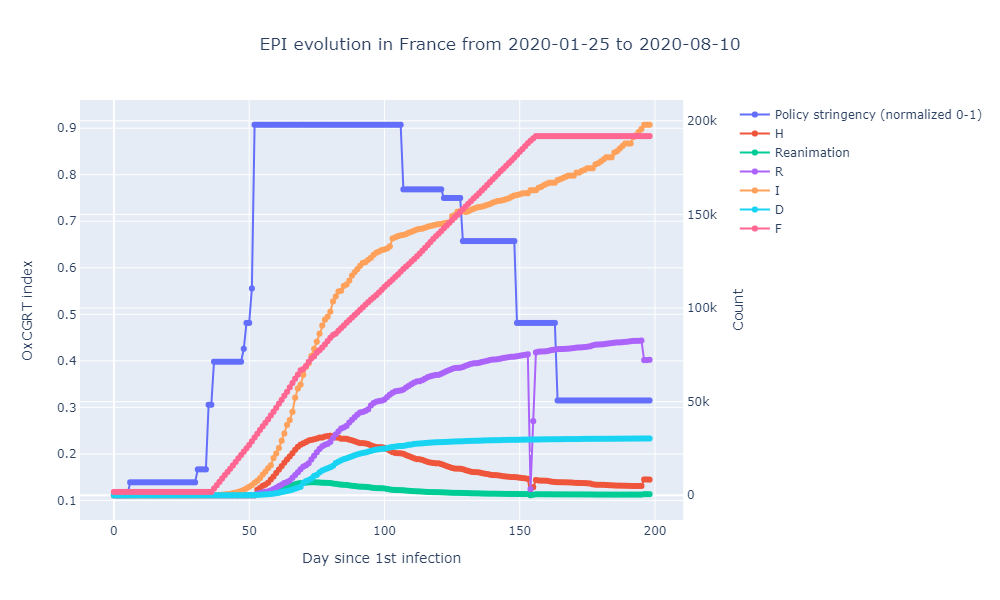

In [10]:
EPI_data, country_attrs = country_covid(COUNTRY, owid_file, hosp_file)
# Add daily deaths data if available
if DEATHS_FILE != '' and COUNTRY == 'France':
    deaths_data = pd.read_csv(DATA_PATH+'/'+DEATHS_FILE, sep=",",header=0)
    EPI_data = EPI_data.merge(deaths_data, on='date', how='outer')
    # Compute collateral deaths
    EPI_data['F'] = EPI_data['D_total'] - EPI_data['D']
    EPI_data.drop(['D_total'], axis=1, inplace=True)
#     EPI_data['dD'] = EPI_data['D'].diff()
#     EPI_data['dF'] = EPI_data['F'].diff()
    EPI_data.ffill(axis=0, inplace=True)
    EPI_data.bfill(axis=0, inplace=True)
    
    
plotcols = [c for c in EPI_data.columns if c not in ['date', 's', 'N_effective', 'S']]
plot_dualaxis(len(EPI_data),
              [EPI_data[c]/(1 + 99*int(c == 's')) for c in ['s']],
              [EPI_data[c] for c in plotcols], 
              ['Policy stringency (normalized 0-1)', 'OxCGRT index'], 
              plotcols + ['Count'], 
              f'EPI evolution in {COUNTRY} from {EPI_data.date[0]} to {EPI_data.date[len(EPI_data)-1]}', 
              log_y2=False,
              static=STATIC_PLOTS, 
              xtitle='Day since 1st infection')

### Model fitting

Parameters for model fitting: keep $I,D,s$ and start days on $t_0$ where $t_0 = \text{argmin} I_{t_0}>0$

In [11]:
# Flag to vary or freeze disease static parameters: gamma, sigma, nu
disease_vary = True
# Proportion of the population over different sectors (must sum to 100)
sector_props = [100.0]
# Number of days at the end of data series to ignore during model fitting
out_days = 0
# Whether to plot after fitting
plot=True

Fitting France data with 0 last days out
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2634
    # data points      = 396
    # variables        = 11
    chi-square         = 1.5693e+10
    reduced chi-square = 40760451.0
    Akaike info crit   = 6950.04057
    Bayesian info crit = 6993.83613
##  Warning: uncertainties could not be estimated:
    gamma:  at boundary
    mu:     at initial value
[[Variables]]
    C_0:    0.39537108 (init = 0.3384672)
    L_0:   -0.38934229 (init = -0.3324051)
    a_0:    0.15522418 (init = 0.1332714)
    b_0:    60.0692891 (init = 59.99095)
    muC_0:  0.01279322 (init = 0.03)
    muL_0: -0.01046763 (init = 0)
    mua_0:  0.93458084 (init = 1)
    mub_0: -64.5793576 (init = 0)
    sigma:  0.16490693 (init = 0.142857)
    gamma:  7.5243e-09 (init = 0.1)
    mu:     0.00371000 (init = 0.00371)
    nu:     0 (fixed)
None
198 fitted days out of 198 available data points


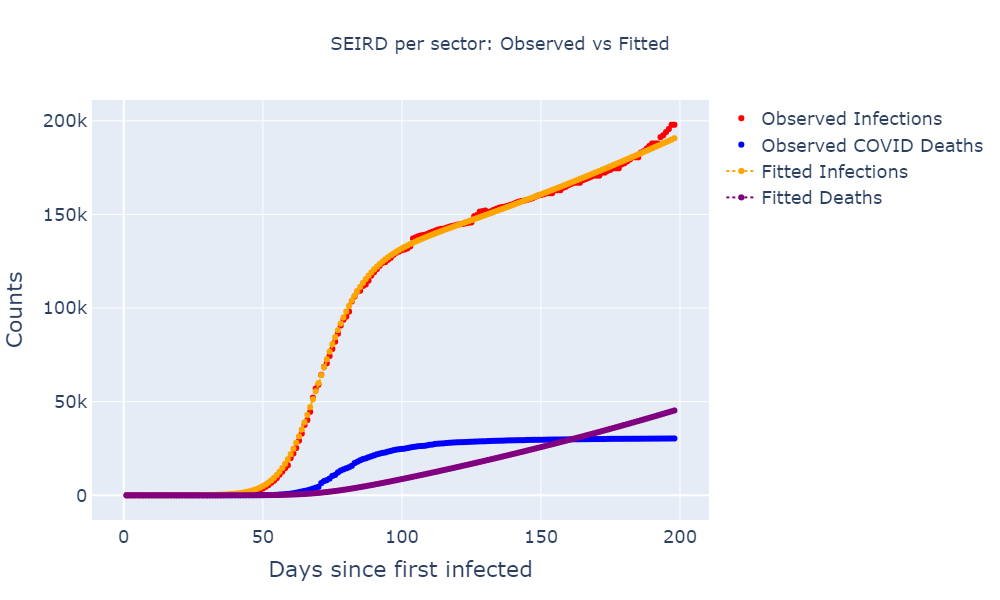

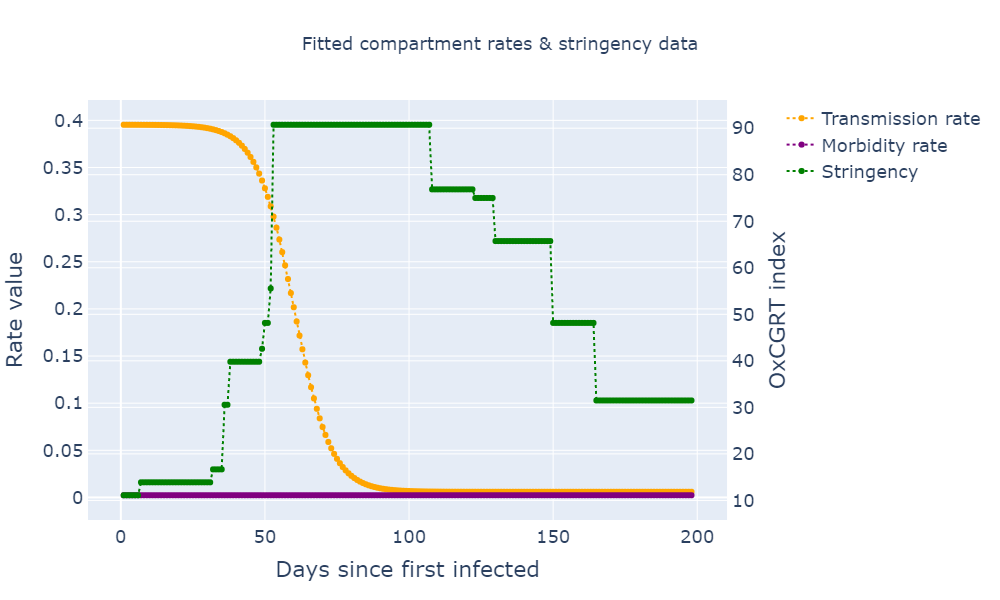

In [12]:
data_s, result,initN = fit(country=COUNTRY, out_days=out_days, plot=plot, disease_vary=disease_vary, sector_props=sector_props)

### Fitted model simulation

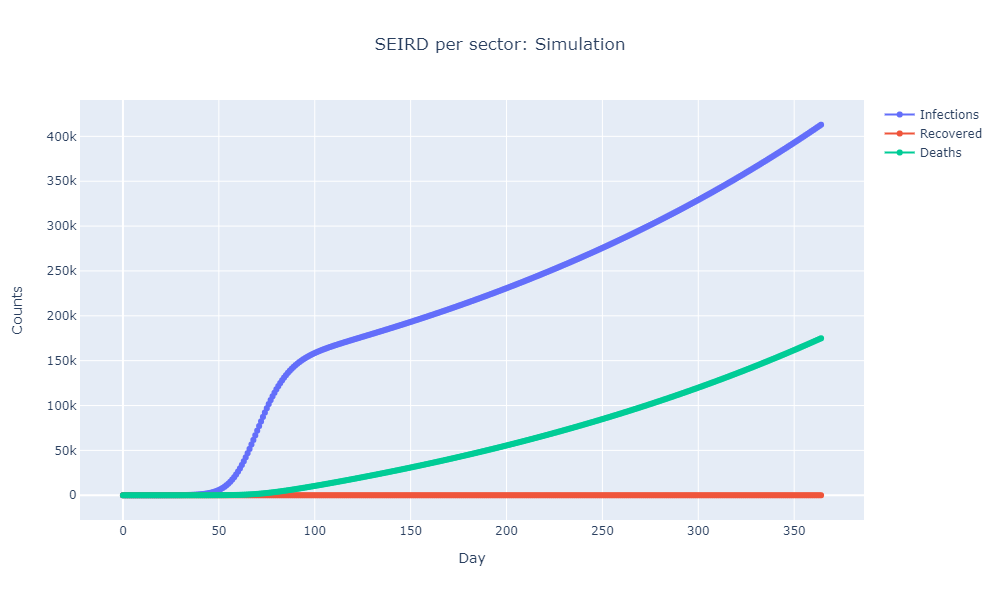

In [13]:
simulation_days = 365
initial_conditions= [[0.0, 1.0, 0.0, initN, 0.0, 0.0]]
simulate_plot(result, simulation_days, initial_conditions, static=STATIC_PLOTS)